# KOH Posterior Analysis using Mici

This notebook looks at the different ways to implement an MCMC algorithm using Gaussian random-walk Metropolis proposal under the Mici framework.

The goal is to discover the best set-up and compare results against the MATLAB code previously implemented.

First, import the required packages and set up the KOH and Mici frameworks.

In [2]:
import model1 as mm
from dataloader import DataLoader
from kohgpjax.mappings import mapRto01, map01toR, mapRto0inf, map0inftoR
from MATLAB_mappings import ell2rho, beta2ell
from jax import jit

import numpy as np
import mici

import matplotlib.pyplot as plt

import arviz

plot_style = {
    'mathtext.fontset': 'cm',
    'font.family': 'serif',
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 150,
}

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [3]:
seed = 1234
n_chain = 1 # only 1 works on MacOS
n_dim = 7
n_warm_up_iter = 4000
n_main_iter = 10000
rng = np.random.default_rng(seed)

init_states = np.array([[
    map01toR(0.4257), 
    map0inftoR(beta2ell(51.5551)), #these are the beta values!!!
    map0inftoR(beta2ell(3.5455)), 
    map0inftoR(beta2ell(2)), 
    map0inftoR(0.25557), 
    map0inftoR(37.0552), 
    map0inftoR(10030.5142), 
    map0inftoR(79548.2126)
]])

param_transform_mici_to_gpjax = lambda x: [
    [ # theta (calibration) parameters
        mapRto01(x[0])
    ],
    [ # lengthscale parameters
        mapRto0inf(x[1]), 
        mapRto0inf(x[2]),
        mapRto0inf(x[3])
    ],
    [ # lambda (variance) parameters
        mapRto0inf(x[4]), 
        mapRto0inf(x[5]), 
        mapRto0inf(x[6]), 
        mapRto0inf(x[7])
    ]
]

tmax = 0.6
tmin = 0.2


##### KOH Model #####
dataloader = DataLoader('data/simple_field.csv', 'data/simple_comp.csv')
data = dataloader.get_data() # loads normalised/standardised data
model = mm.MatlabModel(*data)
jitted_neg_log_posterior_density = jit(
    model.get_KOH_neg_log_pos_dens_func(
        param_transform_mici_to_gpjax
    )
)

##### Mici #####
system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=jitted_neg_log_posterior_density,
    grad_neg_log_dens=lambda q: q * 0,
)
integrator = mici.integrators.LeapfrogIntegrator(system)

## Setup 1

Adapters:
- DualAveragingStepSizeAdapter(0.234)
- OnlineCovarianceMetricAdapter()

Results:
- Fails to achieve the target acceptance rate of 0.234, instead achieves around 0.2
- ESS bulk values are very similar for each variable.
- Parameter estimate for $\theta$ is very good. 
- 

In [4]:
##### Mici sampler and adapters #####
sampler = mici.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=1)
adapters = [
    mici.adapters.DualAveragingStepSizeAdapter(0.234),
    mici.adapters.OnlineCovarianceMetricAdapter()
]

def trace_func(state):
    return {
        'theta': state.pos[0], 
        'ell_eta_1': state.pos[1], 
        'ell_eta_2': state.pos[2],
        'ell_delta_1': state.pos[3],
        'lambda_eta': state.pos[4],
        'lambda_delta': state.pos[5],
        'lambda_epsilon': state.pos[6],
        'lambda_epsilon_eta': state.pos[7],
    }

final_states, traces, stats = sampler.sample_chains(
    n_warm_up_iter, 
    n_main_iter, 
    init_states, 
    adapters=adapters, 
    n_process=n_chain, # only 1 works on MacOS
    trace_funcs=[trace_func]
)

Sampling stage: Initial fast adaptive [00:00] > Slow adaptive (1/7) [00:00] > Slow adaptive (2/7) [00:00] > Slow adaptive (3/7) [00:00] > Slow adaptive (4/7) [00:00] > Slow adaptive (5/7) [00:01] > Slow adaptive (6/7) [00:03] > Slow adaptive (7/7) [00:10] > Final fast adaptive [00:00] > Main non-adaptive [00:43]

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


Chain 1/1: 100%|██████████|10000/10000 [00:43<00:00, 228.90it/s, accept_stat=0.367]

# Analyse the Chains

In [5]:
arviz.summary(traces)

Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,-0.264,0.153,-0.564,0.015,0.010,0.007,243.0,88.0,NaN
ell_eta_1,-2.335,0.030,-2.393,-2.279,0.002,0.001,380.0,690.0,NaN
ell_eta_2,-0.954,0.055,-1.057,-0.848,0.003,0.002,318.0,521.0,NaN
ell_delta_1,-78.875,49.443,-145.269,-2.306,44.090,44.412,1.0,13.0,NaN
lambda_eta,-1.346,0.205,-1.754,-0.990,0.010,0.007,415.0,726.0,NaN
lambda_delta,3.502,0.291,2.930,4.003,0.016,0.011,421.0,393.0,NaN
lambda_epsilon,9.025,0.342,8.378,9.641,0.018,0.013,354.0,604.0,NaN
lambda_epsilon_eta,11.265,0.108,11.059,11.458,0.006,0.004,355.0,933.0,NaN


In [6]:
for var, trace in traces.items():
    print(var, ": ", np.mean(trace[0]), '±', np.std(trace[0]))

# for i in range(7):
#     print(np.mean(traces['pos'][0][:, i]), '±', np.std(traces['pos'][0][:, i]))

theta :  -0.2637734293243201 ± 0.15259101005718964
ell_eta_1 :  -2.33533372874311 ± 0.03004455171418415
ell_eta_2 :  -0.9536008272605464 ± 0.055367331467032606
ell_delta_1 :  -78.87521884431253 ± 49.44055302195504
lambda_eta :  -1.3459020510324309 ± 0.20468134064813667
lambda_delta :  3.501912351360539 ± 0.2912084165622948
lambda_epsilon :  9.024533284256083 ± 0.3423485480694624
lambda_epsilon_eta :  11.265111140493776 ± 0.10750348548581717


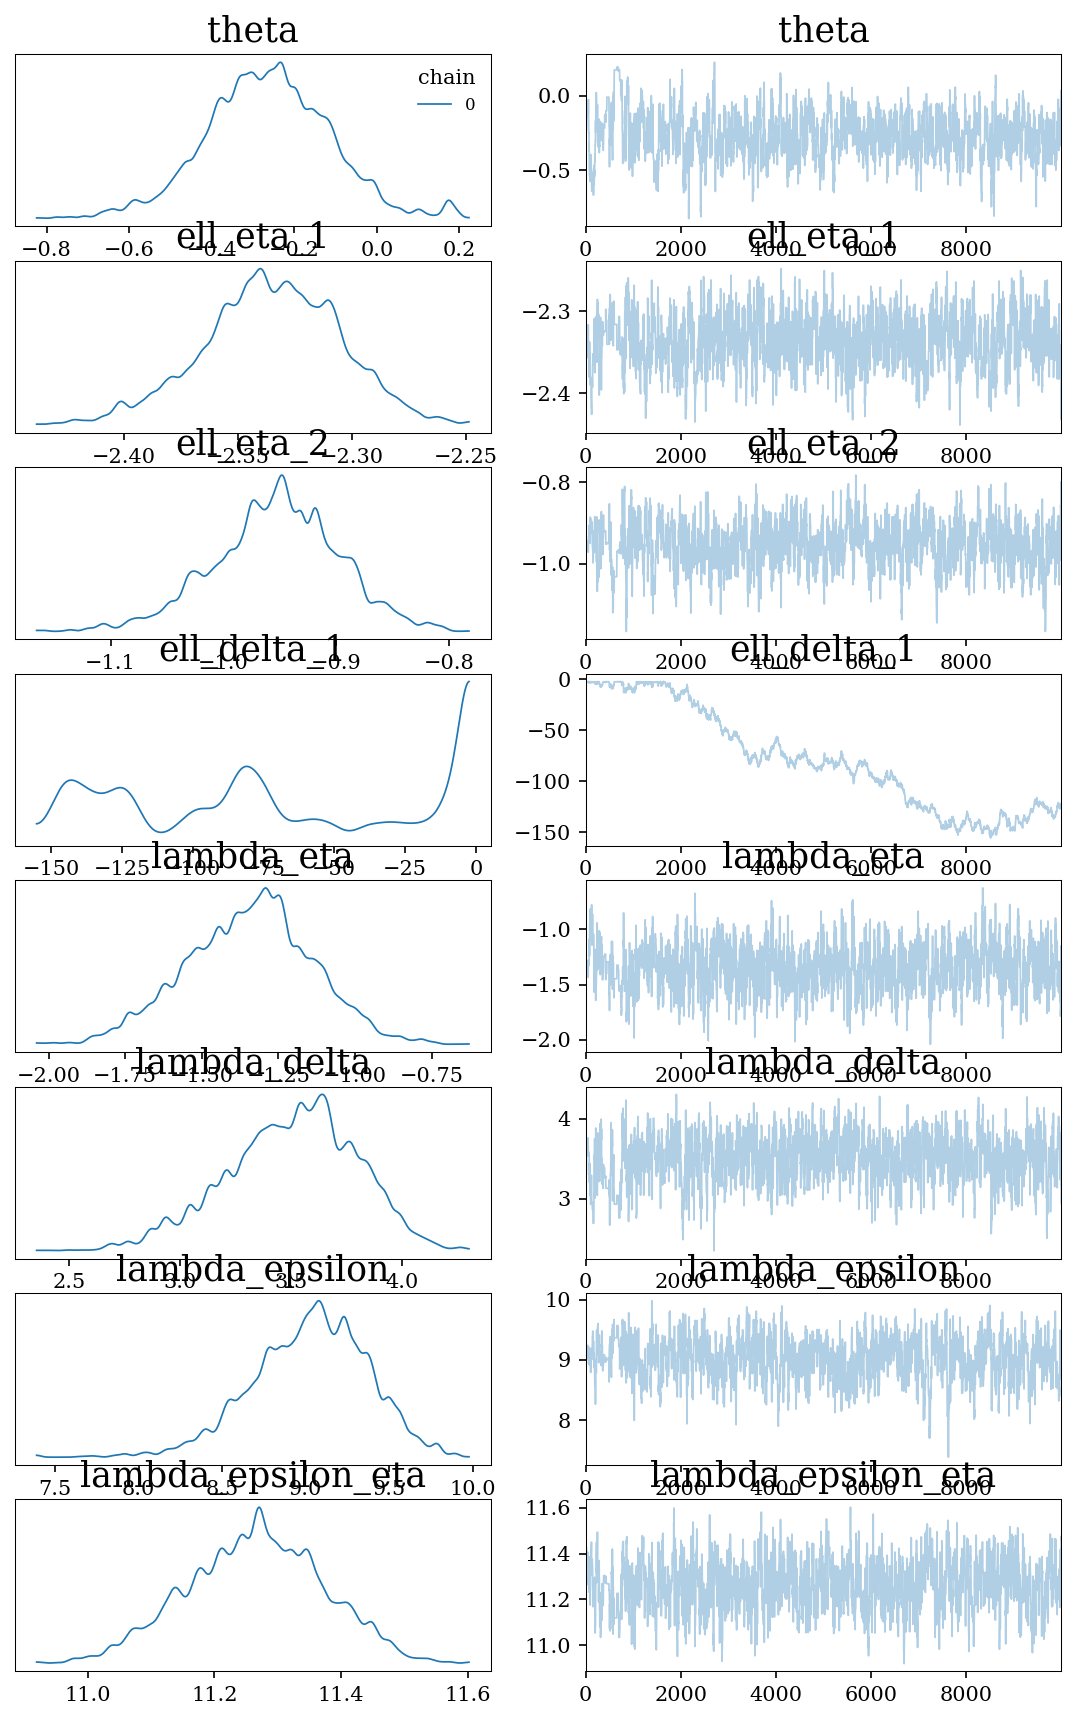

In [7]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces,
        # var_names=["σ", "ϵ", "γ", "β", "x_0"],
        figsize=(9, 2 * (7)),
        legend=True,
        compact=False,
    )
plt.show()

# Transform the Chains

In [8]:
traces_transformed = {}
for var, trace in traces.items():
    if var == 'theta':
        traces_transformed[var] = mapRto01(trace[0])*(tmax-tmin) + tmin
    elif var == 'ell_eta_1' or var == 'ell_eta_2':
        traces_transformed[var] = ell2rho(mapRto0inf(trace[0]))
    else:
        traces_transformed[var] = mapRto0inf(trace[0])

for var, trace in traces_transformed.items():
    print(var, ": ", np.mean(trace), '±', np.std(trace))


# traces_transformed = {'pos': []}
# traces_transformed['pos'].append(np.empty_like(traces['pos'][0]))
# for i in range(0, 1): # theta
#     traces_transformed['pos'][0][:, i] = mapRto01(traces['pos'][0][:, i])*(tmax-tmin) + tmin
# for i in range(1, 3): # rho_eta, rho_delta
#     traces_transformed['pos'][0][:, i] = ell2rho(mapRto0inf(traces['pos'][0][:, i]))
# for i in range(3, 7): # lambda_eta, lambda_delta, lambda_epsilon, lambda_epsilon_eta
#     traces_transformed['pos'][0][:, i] = mapRto0inf(traces['pos'][0][:, i])

# for i in range(7):
#     print(np.mean(traces_transformed['pos'][0][:, i]), '±', np.std(traces_transformed['pos'][0][:, i]))


theta :  0.42607954259976677 ± 0.014916914431347064
ell_eta_1 :  2.1031491485208327e-06 ± 1.6981793230727141e-06
ell_eta_2 :  0.4306149793015595 ± 0.0400288021183996
ell_delta_1 :  0.006805414275428857 ± 0.02031444090525169
lambda_eta :  0.26578463272888847 ± 0.05449582201363391
lambda_delta :  34.571252298746316 ± 9.78008628501366
lambda_epsilon :  8784.274858055402 ± 2906.4675425769587
lambda_epsilon_eta :  78501.66506697788 ± 8427.63785549963


In [9]:
arviz.summary(traces_transformed)

Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.426,0.015,0.398,0.455,0.001,0.001,243.0,85.0,NaN
ell_eta_1,0.000,0.000,0.000,0.000,0.000,0.000,380.0,690.0,NaN
ell_eta_2,0.431,0.040,0.355,0.506,0.002,0.002,318.0,521.0,NaN
ell_delta_1,0.007,0.020,0.000,0.059,0.009,0.006,1.0,13.0,NaN
lambda_eta,0.266,0.054,0.173,0.372,0.003,0.002,415.0,726.0,NaN
lambda_delta,34.571,9.781,16.614,51.741,0.461,0.326,421.0,393.0,NaN
lambda_epsilon,8784.275,2906.613,3894.267,14318.535,152.038,107.593,354.0,604.0,NaN
lambda_epsilon_eta,78501.665,8428.059,63392.478,94445.909,451.410,320.261,355.0,933.0,NaN


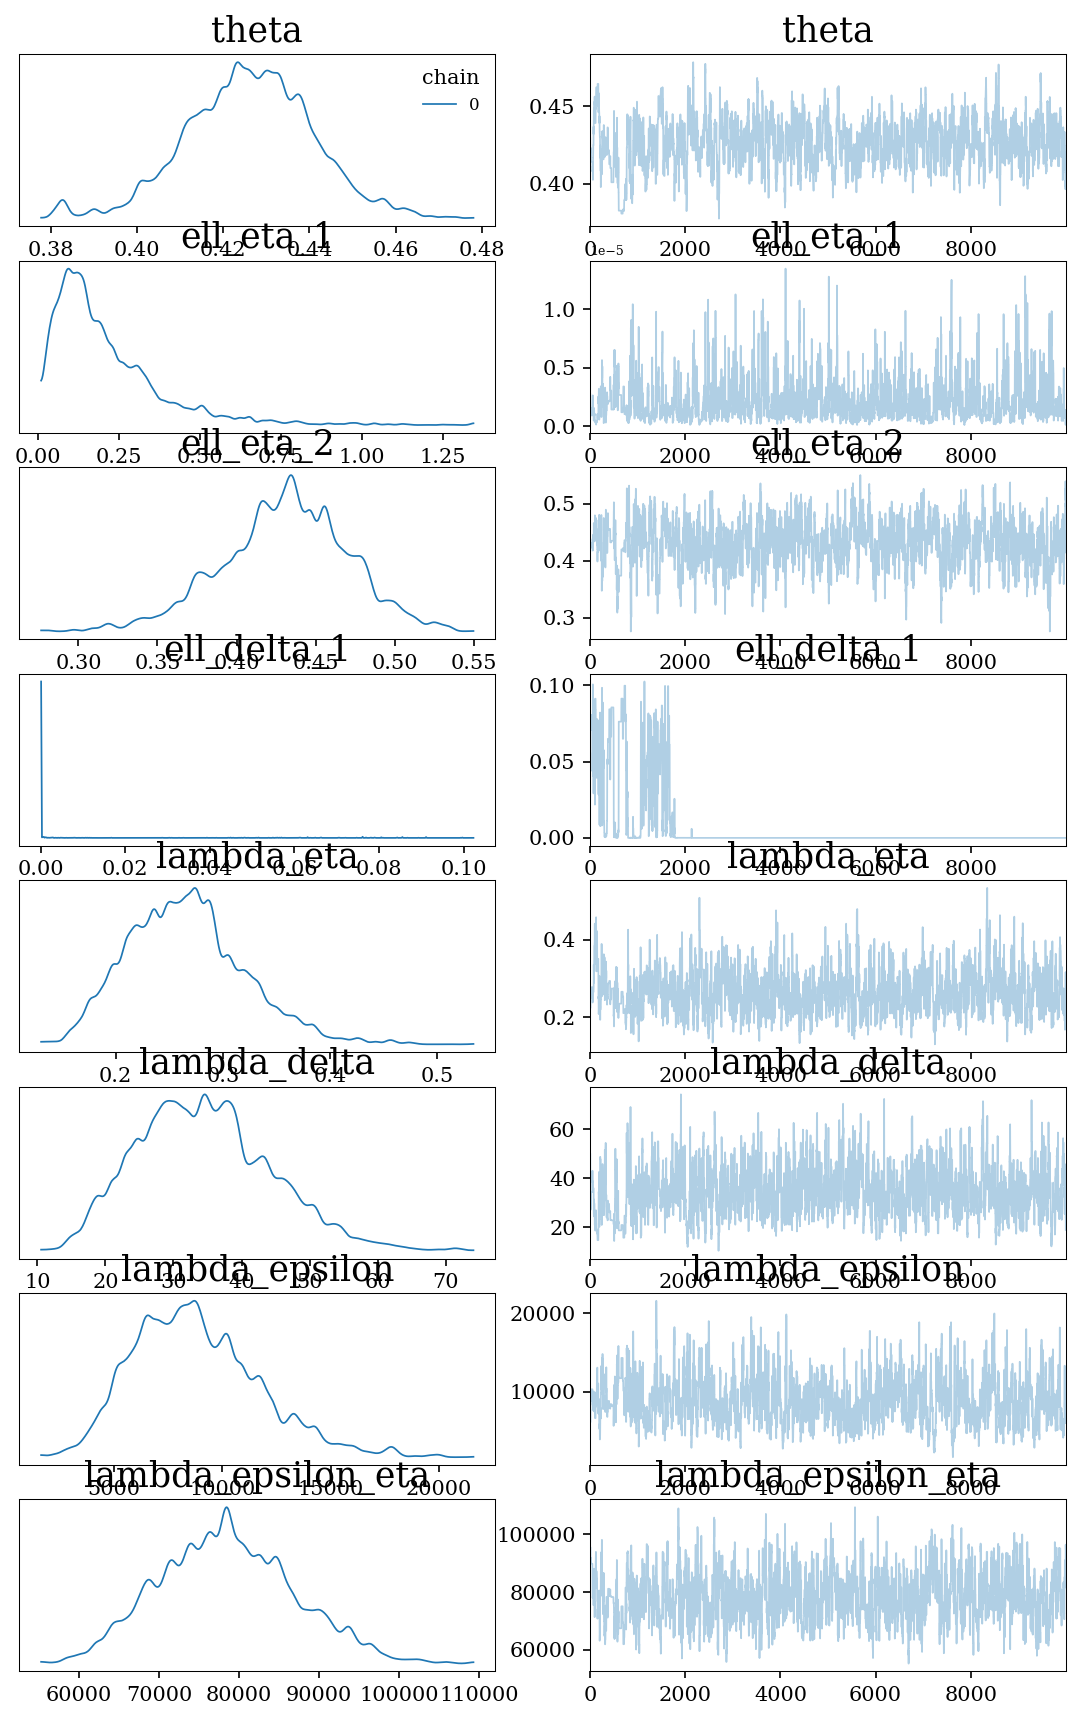

In [10]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces_transformed,
        figsize=(9, 2 * (7)),
        legend=True,
        compact=False,
    )
plt.show()